# CODEATHON 2: Recognizing UVA landmarks with neural nets (50 pts)
![UVA Grounds](https://giving.virginia.edu/sites/default/files/2019-02/jgi-teaser-image.jpg)

The UVA Grounds is known for its Jeffersonian architecture and place in U.S. history as a model for college and university campuses throughout the country. Throughout its history, the University of Virginia has won praises for its unique Jeffersonian architecture.

In this codeathon, you will attempt the build an image recognition system to classify different buildlings/landmarks on Grounds. You will earn 50 points for this codeathon plus 10 bonus points. To make it easier for you, some codes have been provided to help you process the data, you may modify it to fit your needs.

You must submit the .ipynb file via UVA Collab with the following format: **yourUVAComputingID_codeathon_2.ipynb**

In [ ]:
import sys
import sklearn
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from functools import partial
from sklearn.datasets import load_files

%tensorflow_version 2.x
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing import image
from tqdm import tqdm # progress bar
import seaborn as sns
import pandas as pd
from keras.preprocessing.image import load_img, img_to_array
from keras import layers, models
from keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
import pandas as pd
import seaborn as sns

np.random.seed(42)
tf.random.set_seed(42)

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


# Step 1: Process the  Dataset
The full dataset is huge (+37GB) with +13K images of 18 classes. So it will take a while to download, extract, and process. To save you time and effort, a subset of the data has been resized and compressed to only 379Mb and stored in my Firebase server. This dataset will be the one you will benchmark for your grade. If you are up for a challenge (and perhaps bonus points), contact the instructor for the full dataset!

In [ ]:
# Download dataset from Firebase
!wget https://firebasestorage.googleapis.com/v0/b/uva-landmark-images.appspot.com/o/dataset.zip?alt=media&token=e1403951-30d6-42b8-ba4e-394af1a2ddb7

--2024-11-14 04:00:41--  https://firebasestorage.googleapis.com/v0/b/uva-landmark-images.appspot.com/o/dataset.zip?alt=media
Resolving firebasestorage.googleapis.com (firebasestorage.googleapis.com)... 142.251.184.95, 108.177.121.95, 209.85.145.95, ...
Connecting to firebasestorage.googleapis.com (firebasestorage.googleapis.com)|142.251.184.95|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 397174132 (379M) [application/zip]
Saving to: ‘dataset.zip?alt=media’

dataset.zip?alt=med 100%[===================>] 378.77M   247MB/s    in 1.5s    

2024-11-14 04:00:43 (247 MB/s) - ‘dataset.zip?alt=media’ saved [397174132/397174132]



In [ ]:
# Extract content
!unzip "/content/dataset.zip?alt=media"

Streaming output truncated to the last 5000 lines.
  inflating: dataset/Rotunda/0000010694.jpg  
  inflating: __MACOSX/dataset/Rotunda/._0000010694.jpg  
  inflating: dataset/Rotunda/0000010680.jpg  
  inflating: __MACOSX/dataset/Rotunda/._0000010680.jpg  
  inflating: dataset/Rotunda/0000010858.jpg  
  inflating: __MACOSX/dataset/Rotunda/._0000010858.jpg  
  inflating: dataset/Rotunda/0000010870.jpg  
  inflating: __MACOSX/dataset/Rotunda/._0000010870.jpg  
  inflating: dataset/Rotunda/0000010864.jpg  
  inflating: __MACOSX/dataset/Rotunda/._0000010864.jpg  
  inflating: dataset/Rotunda/0000010865.jpg  
  inflating: __MACOSX/dataset/Rotunda/._0000010865.jpg  
  inflating: dataset/Rotunda/0000010871.jpg  
  inflating: __MACOSX/dataset/Rotunda/._0000010871.jpg  
  inflating: dataset/Rotunda/0000010859.jpg  
  inflating: __MACOSX/dataset/Rotunda/._0000010859.jpg  
  inflating: dataset/Rotunda/0000010681.jpg  
  inflating: __MACOSX/dataset/Rotunda/._0000010681.jpg  
  inflating: dataset/R

In [ ]:

data_dir = "/content/dataset/"
batch_size = 32;
# IMPORTANT: Depends on what pre-trained model you choose, you will need to change these dimensions accordingly
img_height = 224
img_width = 224

# Training Dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset = "training",
    seed = 42,
    image_size= (img_height, img_width),
    batch_size = batch_size
)

# Validation Dataset
validation_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset = "validation",
    seed = 42,
    image_size = (img_height, img_width),
    batch_size = batch_size
)

Found 14286 files belonging to 18 classes.
Using 11429 files for training.
Found 14286 files belonging to 18 classes.
Using 2857 files for validation.


In [ ]:
type(train_ds)

tensorflow.python.data.ops.prefetch_op._PrefetchDataset

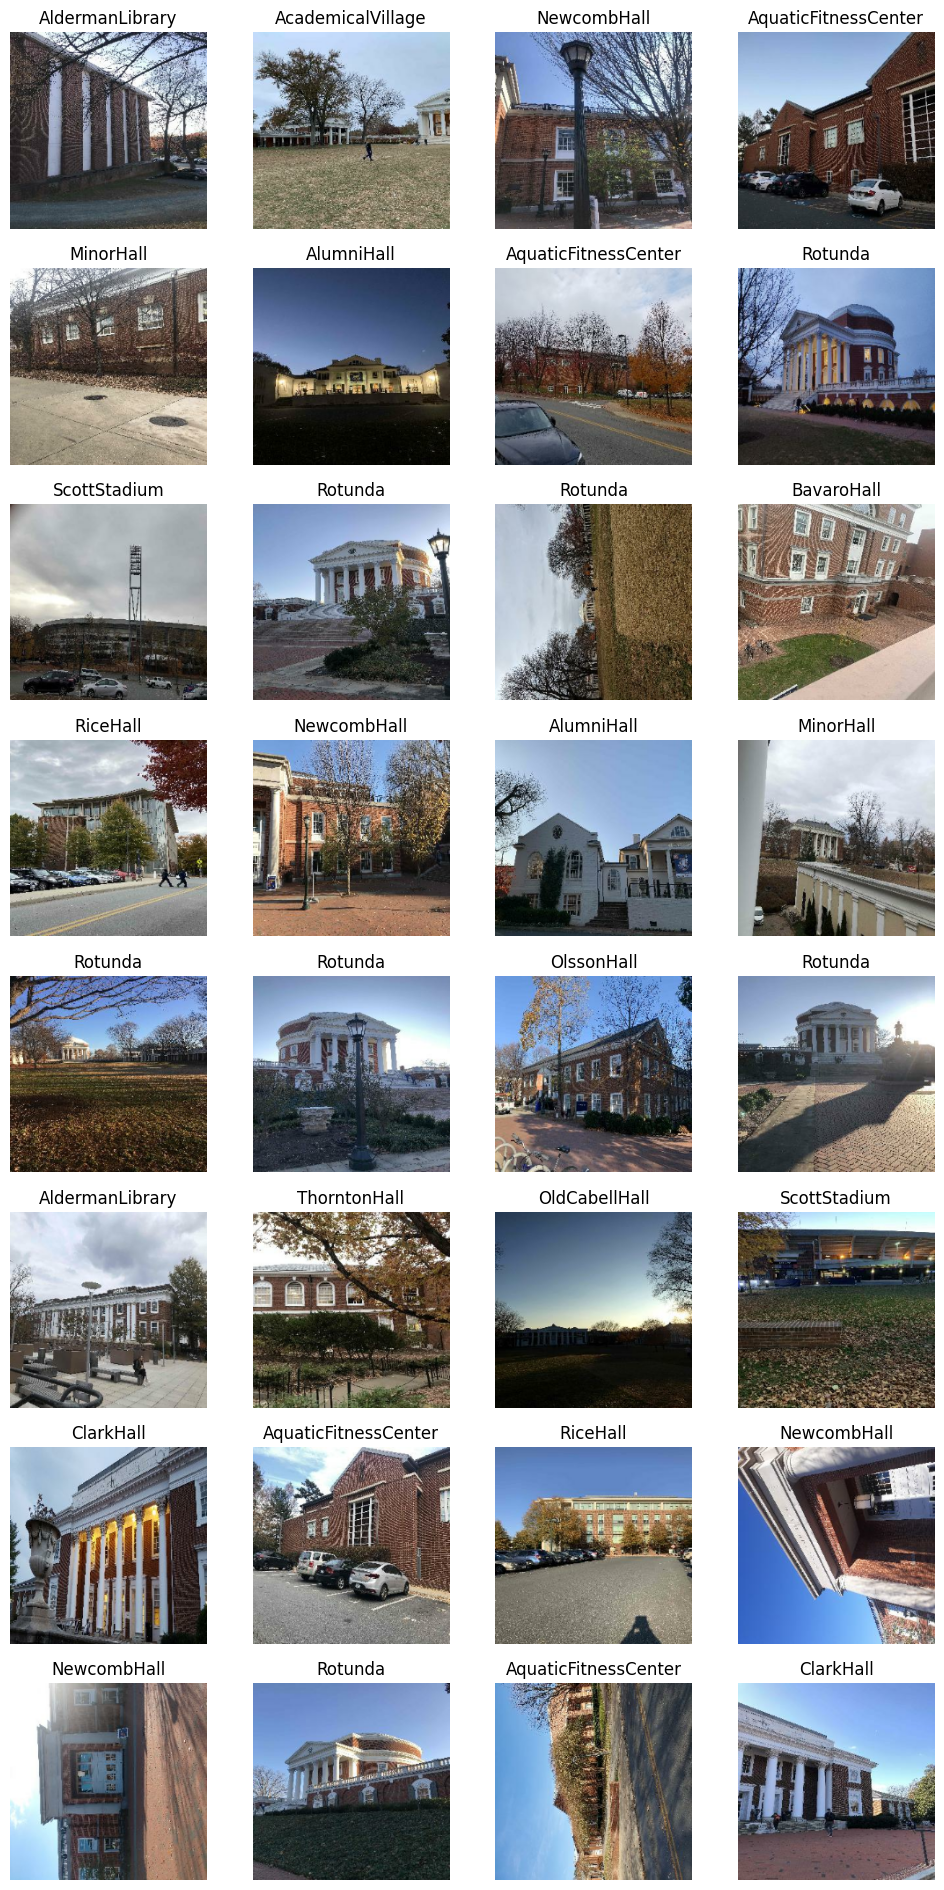

In [ ]:
# Visualize some of the train samples of one batch
# Make sure you create the class names that match the order of their appearances in the "files" variable
class_names = ['AcademicalVillage', 'AldermanLibrary', 'AlumniHall', 'AquaticFitnessCenter',
  'BavaroHall', 'BrooksHall', 'ClarkHall', 'MadisonHall', 'MinorHall', 'NewCabellHall',
  'NewcombHall', 'OldCabellHall', 'OlssonHall', 'RiceHall', 'Rotunda', 'ScottStadium',
  'ThorntonHall', 'UniversityChapel']

# Rows and columns are set to fit one training batch (32)
n_rows = 8
n_cols = 4
plt.figure(figsize=(n_cols * 3, n_rows * 3))
for images, labels in train_ds.take(1):
    for i in range (n_rows*n_cols):
        plt.subplot(n_rows, n_cols, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.axis('off')
        plt.title(class_names[labels[i]], fontsize=12)
plt.subplots_adjust(wspace=.2, hspace=.2)


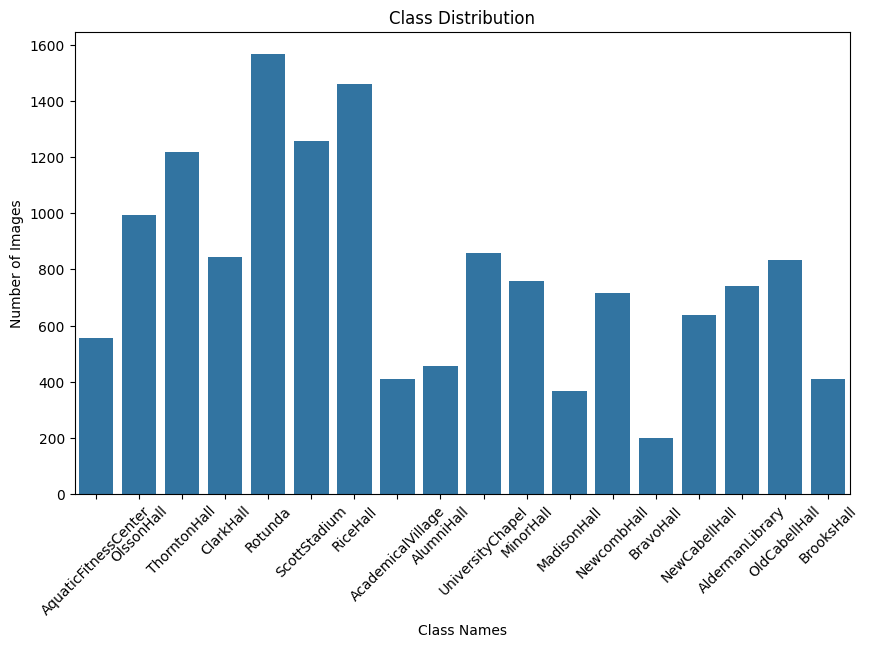

In [ ]:
# Checking for class imbalance

class_counts = {}
for class_name in os.listdir(data_dir):
    class_path = os.path.join(data_dir, class_name)
    if os.path.isdir(class_path):
        class_counts[class_name] = len(os.listdir(class_path))

plt.figure(figsize=(10, 6))
sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()))
plt.xticks(rotation=45)
plt.title("Class Distribution")
plt.xlabel("Class Names")
plt.ylabel("Number of Images")
plt.show()

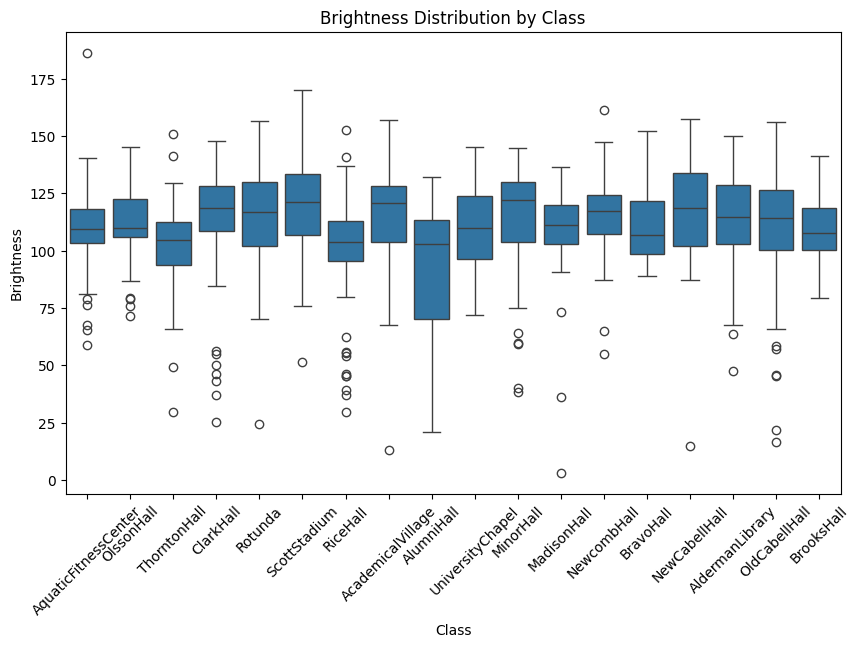

In [ ]:
# Checking brightness distribution

brightness_values = []
for class_name in class_counts.keys():
    class_path = os.path.join(data_dir, class_name)
    for img_name in os.listdir(class_path)[:50]:  # Sample 50 images per class
        img = load_img(os.path.join(class_path, img_name), color_mode="grayscale")
        img_array = img_to_array(img)
        brightness = np.mean(img_array)
        brightness_values.append((class_name, brightness))

# Plot brightness distribution
brightness_df = pd.DataFrame(brightness_values, columns=["Class", "Brightness"])
plt.figure(figsize=(10, 6))
sns.boxplot(data=brightness_df, x="Class", y="Brightness")
plt.xticks(rotation=45)
plt.title("Brightness Distribution by Class")
plt.show()

### Notes from the data:
*   Seasons: mostly fall and winter
*   Weather: almost all are during the day and partially cloudy - some evening/morning/night or overcast
*   View Angles: mostly from the front or slightly oblique & some photos rotated 90 degrees (otherwise no rotation)
*  CLass imbalance: a lot more rotunda & other famous buildings
*  Obstructions: I notice a lot of trees and sometimes there are also people in the way


### Ideas top try


*   begin w/ downsampling (may be faster)
*   grayscale (may be faster)
*   how to emphasize prominent feature learning?
*   obstruction handling: background segmentation OR inital fine-tuning layers
*   augmentations:brightness - contrast - temperature - rotation
*   augment under-represented classes
*   class imbalance compensation with weighted errors



# Step 2: Create your own CNN architecture
You must design your own architecture. To get started, you may get inspiration from one in CNN notebook  (i.e. use one similar to LeNet-5 or AlexNet). You will have to report the design of the architecture:

1.   How many layers does it have?
* 4 Convolutional Layers with ReLU activations
* 4 MaxPooling Layers after each convolutional layer
* 1 Flatten or GlobalAveragePooling Layer (depends on the final decision)
* 1 Dense Layer with 256 nodes
* 1 Dropout Layer
* 1 Output Dense Layer with softmax activation for classification
2.   Why do you decide on a certain number nodes per layer?

The filters increase from 32 to 128 across layers (32, 64, 128, 128). This gradual increase helps the model learn progressively complex features.
Lower filter counts in initial layers reduce computational load while capturing basic features (edges, textures). Higher filters in later layers capture more complex patterns.
3.   Which activation functions do you choose?

I chose ReLU because it is commonly used in CNNs due to its simplicity and ability to mitigate the vanishing gradient problem, which enables deeper networks to train effectively.
4.   How many parameters does it has in total?
Total params: 1851346 (7.06 MB)
Trainable params: 1851346 (7.06 MB)



In [ ]:

num_classes = 18

# LeNet-5 style
myModel = models.Sequential([
    # First Convolutional Block
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    layers.MaxPooling2D((2, 2)),

    # Second Convolutional Block
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    # Third Convolutional Block
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    # Fourth Convolutional Block (Deepening the network for complex features)
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    # Flatten the results and feed into dense layers
    layers.Flatten(),
    layers.Dense(256, activation='relu'),  # Dense layer for learning complex feature combinations
    layers.Dropout(0.5),  # Dropout for regularization

    # Output layer for classification
    layers.Dense(len(class_names), activation='softmax')
])
myModel.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 15, 15, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 6272)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       1,605,888 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 18)                  │           4,626 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,851,346 (7.06 MB)

 Trainable params: 1,851,346 (7.06 MB)

 Non-trainable params: 0 (0.00 B)

After designing the model, you will need to train it. In order to train, you will need to pick a number of `epoch` (iteration), which `optimizer` to use (from  `keras.optimizers`), a `loss` function, and some `metrics`.

In [ ]:

myEpochs = 30
myOptimizer = Adam(learning_rate=0.001)
myLoss = 'sparse_categorical_crossentropy'  # Suitable for multi-class classification with integer labels
myMetrics = ['accuracy', 'top_k_categorical_accuracy']  # Top-k accuracy can provide insight into model's generalization
myModel.compile(loss= myLoss, optimizer = myOptimizer, metrics = myMetrics)
history = myModel.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=myEpochs
)

myModel.compile(loss=myLoss, optimizer=myOptimizer, metrics=myMetrics)



Epoch 1/30
358/358 [==============================] - 60s 165ms/step - loss: 3.2727 - accuracy: 0.1583 - top_k_categorical_accuracy: 0.0420 - val_loss: 2.5664 - val_accuracy: 0.1988 - val_top_k_categorical_accuracy: 0.0200
Epoch 2/30
358/358 [==============================] - 58s 163ms/step - loss: 2.4056 - accuracy: 0.2695 - top_k_categorical_accuracy: 0.1188 - val_loss: 2.1167 - val_accuracy: 0.3535 - val_top_k_categorical_accuracy: 0.1351
Epoch 3/30
358/358 [==============================] - 58s 163ms/step - loss: 2.1153 - accuracy: 0.3637 - top_k_categorical_accuracy: 0.1494 - val_loss: 1.8949 - val_accuracy: 0.4214 - val_top_k_categorical_accuracy: 0.1173
Epoch 4/30
358/358 [==============================] - 58s 161ms/step - loss: 1.8183 - accuracy: 0.4559 - top_k_categorical_accuracy: 0.1622 - val_loss: 1.6753 - val_accuracy: 0.5016 - val_top_k_categorical_accuracy: 0.1565
Epoch 5/30
358/358 [==============================] - 58s 161ms/step - loss: 1.5643 - accuracy: 0.5346 - top

Next, you need to create (1) a plot of training and validation `loss` and (2) a plot of training and validation `accuracy`. These plots might give you some insights about your model performance and possibility of overfitting.

Report the performance of your architecture on the validation set in a `confusion matrix`. Make comments on the performance by answering the following questiosns:
- How well do you think your architecture is doing (overall accuracy)?

Not good, it seems like some textbook overfitting has occured as indicated by the comparatively poor performance on the validation set.
- Where did it makes mistake most?

Most mistakes were made on classes that were under-represented in the training set. Variance in brightness didn't seem to make a difference - which is a relief because accounting for that in the next model would've been a huge headache.
- Which classes can be improved?

Improvement needs to be focused on the classes that are under-represented in the training set.


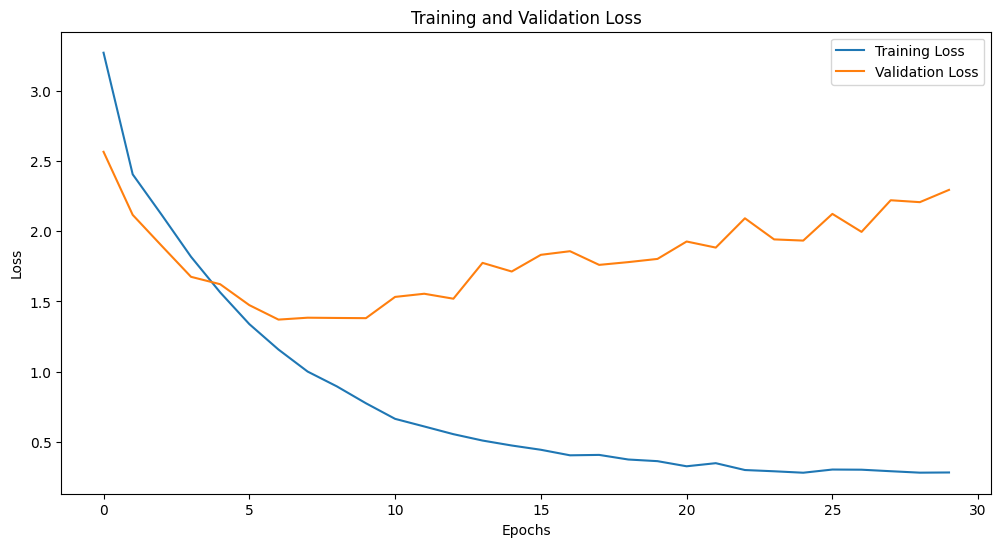

In [ ]:
# Plotting the training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

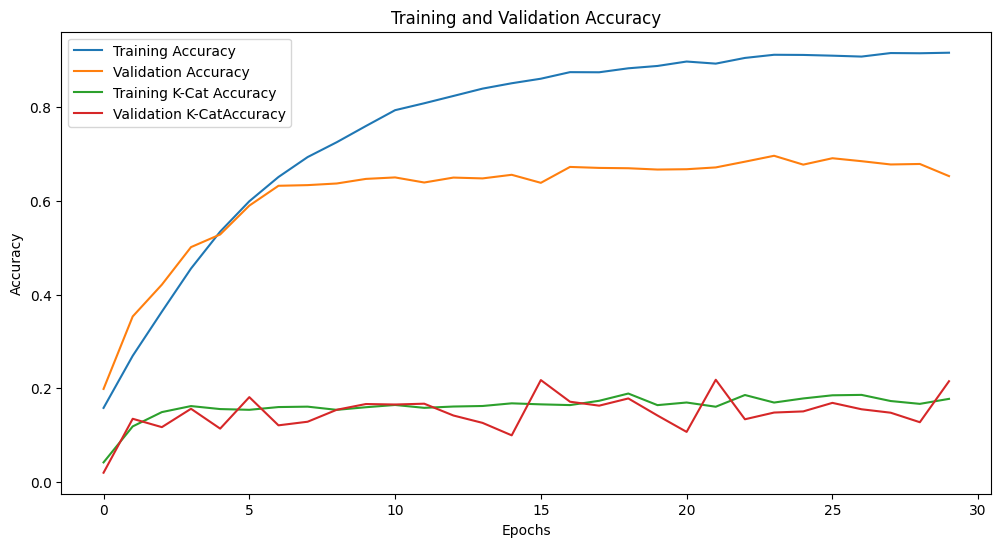

In [ ]:
# Plotting the training and validation accuracy
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['top_k_categorical_accuracy'], label='Training K-Cat Accuracy')
plt.plot(history.history['val_top_k_categorical_accuracy'], label='Validation K-CatAccuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

90/90 [==============================] - 3s 36ms/step


<Figure size 1200x1200 with 0 Axes>

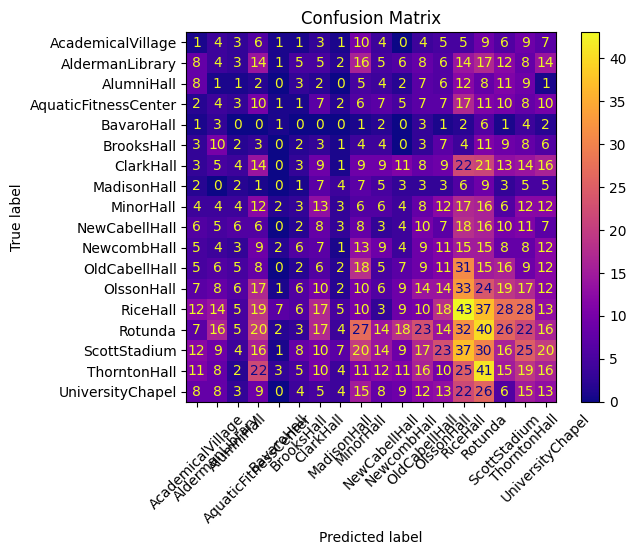

In [ ]:

# Get true labels and predictions for the validation set
val_labels = np.concatenate([y for x, y in validation_ds], axis=0)
val_predictions = np.argmax(myModel.predict(validation_ds), axis=1)

# Generate the confusion matrix
cm = confusion_matrix(val_labels, val_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

# Plot the confusion matrix
plt.figure(figsize=(12, 12))
disp.plot(cmap=plt.cm.plasma, xticks_rotation=45)
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Extract the indices of the most confused pairs using absolute counts
confusion_pairs = []
for i in range(len(class_names)):
    for j in range(len(class_names)):
        if i != j and cm[i, j] > 0:  # Only include non-diagonal elements with positive counts
            confusion_pairs.append((class_names[i], class_names[j], cm[i, j]))

# Sort pairs by confusion count in descending order
confusion_pairs = sorted(confusion_pairs, key=lambda x: x[2], reverse=True)

# Display the most confused pairs with absolute counts
print("Most Confused Classes:")
for pair in confusion_pairs[:10]:  # Show top 10 most confused pairs
    print(f"{pair[0]} confused with {pair[1]}: {pair[2]} times")


Most Confused Classes:
BavaroHall confused with Rotunda: 0.2222222222222222 times
AcademicalVillage confused with RiceHall: 0.16455696202531644 times
NewCabellHall confused with Rotunda: 0.16153846153846155 times
AlumniHall confused with Rotunda: 0.15853658536585366 times
ScottStadium confused with RiceHall: 0.15827338129496402 times
AldermanLibrary confused with RiceHall: 0.1554054054054054 times
MinorHall confused with Rotunda: 0.1527777777777778 times
ClarkHall confused with RiceHall: 0.15204678362573099 times
AcademicalVillage confused with Rotunda: 0.1518987341772152 times
BavaroHall confused with MinorHall: 0.14814814814814814 times


Notes while comparing images of these classes

In [ ]:


# Get true labels and predictions for the validation set
val_labels = np.concatenate([y for x, y in validation_ds], axis=0)
val_predictions = np.argmax(myModel.predict(validation_ds), axis=1)

# Calculate accuracy per class
class_accuracies = []
for i, class_name in enumerate(class_names):
    # Get indices for instances of the current class
    class_indices = np.where(val_labels == i)[0]
    # Calculate accuracy for this class
    class_accuracy = accuracy_score(val_labels[class_indices], val_predictions[class_indices])
    class_accuracies.append(class_accuracy)

# Calculate normalized class representation for the training set
train_labels = np.concatenate([y for x, y in train_ds], axis=0)
class_counts_train = [len(np.where(train_labels == i)[0]) for i in range(len(class_names))]
total_train_samples = sum(class_counts_train)
normalized_class_representation = [count / total_train_samples for count in class_counts_train]

# Plot accuracy per class and normalized class representation
plt.figure(figsize=(12, 8))

# Bar width for side-by-side bars
bar_width = 0.4
index = np.arange(len(class_names))

# Plotting accuracy per class
plt.barh(index - bar_width/2, class_accuracies, bar_width, label='Accuracy per Class', color='skyblue')

# Plotting normalized class representation in training set
plt.barh(index + bar_width/2, normalized_class_representation, bar_width, label='Normalized Class Representation', color='salmon')

# Labeling
plt.xlabel('Proportion / Accuracy')
plt.title('Accuracy per Class and Normalized Class Representation in Training Set')
plt.yticks(index, class_names)
plt.xlim([0, 1])  # Limit x-axis from 0 to 1 for better interpretability
plt.legend()
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


NameError: name 'myModel' is not defined

                      Accuracy  Class Representation  Brightness Variance
Accuracy              1.000000              0.685508             0.402593
Class Representation  0.685508              1.000000             0.445761
Brightness Variance   0.402593              0.445761             1.000000


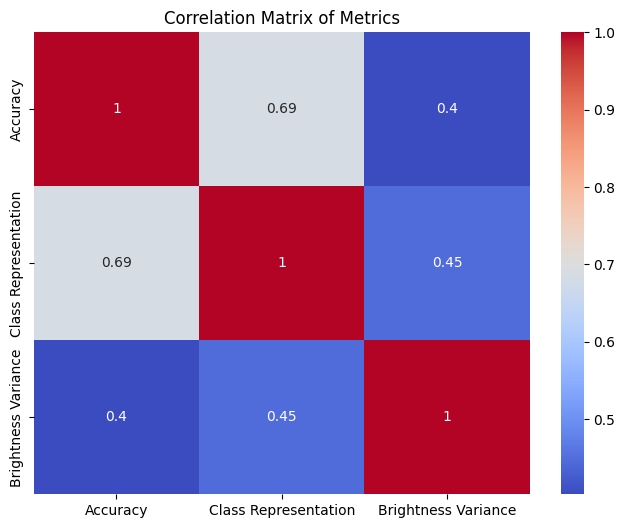

In [ ]:

# Create a DataFrame
data = pd.DataFrame({
    'Class': class_names,
    'Accuracy': class_accuracies,
    'Class Representation': normalized_class_representation,
    'Brightness Variance': brightness_variance_normalized
})

# Compute correlation matrix
correlation_matrix = data[['Accuracy', 'Class Representation', 'Brightness Variance']].corr()
print(correlation_matrix)

# Visualize the correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Metrics')
plt.show()


# Step 3: Use a Pre-trained Network with Transfer Learning
Now that you have a your own custom model and some baseline performance, let's see if you can improve the performance using transfer learning and a pre-trained model. You may use any pre-trained model EXCEPT ones that already provided such as `Xception`, `MobileNet`, `EfficientNetB6`. Keep in mind that each pre-trained model may expect a different input shape, so adjust the size of your training images accordingly.

Make sure you report the design of this architecture by answer the same questions 1-4 in Step 3.

Hint: use `ImageNet` as weights when load the pre-train network, then add a `GlobalAveragePooling2D` and an output layer with `softmax` activation.



In [ ]:
# Pre-Processing

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomTranslation(0.2, 0.2),
])

In [ ]:
from keras.applications import ResNet50V2
from keras.applications.resnet_v2 import preprocess_input

base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

base_model.trainable = False

model = models.Sequential([
    layers.Lambda(preprocess_input, input_shape=(img_height, img_width, 3)),
    # data_augmentation,
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.4),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.4),
    layers.Dense(18, activation='softmax')  # Adjusts to the number of classes
])

# Compile Model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

94668760/94668760 [==============================] - 0s 0us/step


Next, you will attempt to adapt this pre-trained model to your UVA Landmark dataset. It is recommended that you tried the two-phase training approach for your model:

1.   Phase 1: Freeze the pre-train weights and only train the top layer
2.   Phase 2: Train the entire network with much smaller learning rate (adapt the model to UVA data, but avoid destroying the transfered weights).



In [ ]:
# Train the model
history = model.fit(
    train_ds,
    epochs=10,
    validation_data=validation_ds,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)]
)

# Fine-tuning: Unfreeze some layers in the base model
base_model.trainable = True
for layer in base_model.layers[:-10]:
    layer.trainable = False

# Compile Model Again with Lower Learning Rate for Fine-tuning
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Fine-tuning Training
history_fine = model.fit(
    train_ds,
    epochs=10,  # Fewer epochs for fine-tuning
    validation_data=validation_ds,
    callbacks=[
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)]
)

Epoch 1/10
358/358 [==============================] - 186s 510ms/step - loss: 1.5682 - accuracy: 0.5612 - val_loss: 0.8129 - val_accuracy: 0.7679
Epoch 2/10
358/358 [==============================] - 179s 500ms/step - loss: 0.9914 - accuracy: 0.7100 - val_loss: 0.6769 - val_accuracy: 0.8166
Epoch 3/10
358/358 [==============================] - 176s 493ms/step - loss: 0.8504 - accuracy: 0.7451 - val_loss: 0.6644 - val_accuracy: 0.8187
Epoch 4/10
358/358 [==============================] - 177s 494ms/step - loss: 0.7776 - accuracy: 0.7695 - val_loss: 0.6076 - val_accuracy: 0.8334
Epoch 5/10
358/358 [==============================] - 174s 485ms/step - loss: 0.7198 - accuracy: 0.7866 - val_loss: 0.5772 - val_accuracy: 0.8435
Epoch 6/10
358/358 [==============================] - 174s 486ms/step - loss: 0.6785 - accuracy: 0.7954 - val_loss: 0.5552 - val_accuracy: 0.8516
Epoch 7/10
358/358 [==============================] - 174s 488ms/step - loss: 0.6437 - accuracy: 0.8040 - val_loss: 0.5406 -

In [ ]:
model.save('/content/best.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# Additional Training
history_extra = model.fit(
    train_ds,
    epochs=10,  # Fewer epochs for fine-tuning
    validation_data=validation_ds,
    callbacks=[
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)]
)

Epoch 1/10
358/358 [==============================] - 201s 562ms/step - loss: 0.2435 - accuracy: 0.9257 - val_loss: 0.4352 - val_accuracy: 0.8873
Epoch 2/10
358/358 [==============================] - 201s 561ms/step - loss: 0.2261 - accuracy: 0.9333 - val_loss: 0.4301 - val_accuracy: 0.8911
Epoch 3/10
358/358 [==============================] - 200s 560ms/step - loss: 0.2115 - accuracy: 0.9371 - val_loss: 0.4271 - val_accuracy: 0.8897
Epoch 4/10
358/358 [==============================] - 201s 563ms/step - loss: 0.2070 - accuracy: 0.9386 - val_loss: 0.4226 - val_accuracy: 0.8915
Epoch 5/10
358/358 [==============================] - 205s 572ms/step - loss: 0.1827 - accuracy: 0.9477 - val_loss: 0.4179 - val_accuracy: 0.8936
Epoch 6/10
358/358 [==============================] - 203s 566ms/step - loss: 0.1710 - accuracy: 0.9510 - val_loss: 0.4162 - val_accuracy: 0.8939
Epoch 7/10
358/358 [==============================] - 201s 561ms/step - loss: 0.1659 - accuracy: 0.9530 - val_loss: 0.4156 -

In [ ]:
model.save('/content/extra.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Repeat the same reporting of performance using the confusion matrix:
- Did this pre-trained network do better overall?
- In which class it improve the accuracy from the above model?
- Which class still has low performance?

Typically, your network must have a reasonable performance of at least 84% overall accuracy to be considered successful in this domain. If your network achieves a accuracy of 94% or above on the validation set, you will also recieve a 10 bonus points, so keep trying!

In [ ]:
# Concatenating training and validation losses from history_0 and history_fine
combined_loss = history.history['loss'] + history_fine.history['loss']
combined_val_loss = history.history['val_loss'] + history_fine.history['val_loss']

# Plotting the combined training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(combined_loss, label='Training Loss')
plt.plot(combined_val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Combined Training and Validation Loss')
plt.show()

NameError: name 'history' is not defined

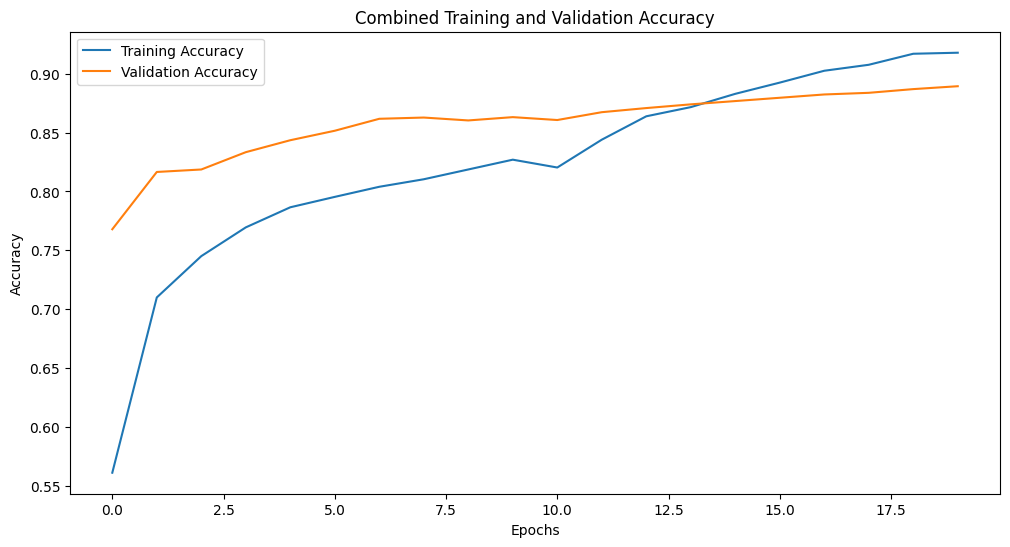

In [ ]:
# Concatenating accuracies from history_0 and history_fine
combined_accuracy = history.history.get('accuracy', []) + history_fine.history.get('accuracy', [])
combined_val_accuracy = history.history.get('val_accuracy', []) + history_fine.history.get('val_accuracy', [])

# Plotting the combined training and validation accuracy
plt.figure(figsize=(12, 6))
plt.plot(combined_accuracy, label='Training Accuracy')
plt.plot(combined_val_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Combined Training and Validation Accuracy')
plt.show()

90/90 [==============================] - 34s 382ms/step


<Figure size 1200x1200 with 0 Axes>

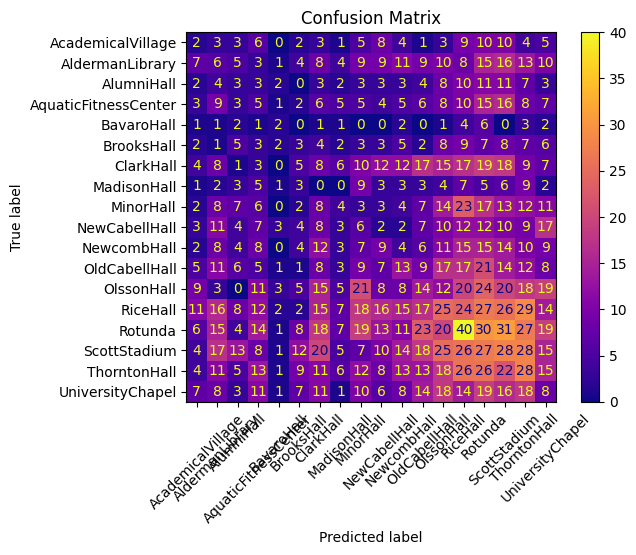

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Get true labels and predictions for the validation set
val_labels = np.concatenate([y for x, y in validation_ds], axis=0)
val_predictions = np.argmax(model.predict(validation_ds), axis=1)

# Generate the confusion matrix
cm = confusion_matrix(val_labels, val_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

# Plot the confusion matrix
plt.figure(figsize=(12, 12))
disp.plot(cmap=plt.cm.plasma, xticks_rotation=45)
plt.title('Confusion Matrix')
plt.show()

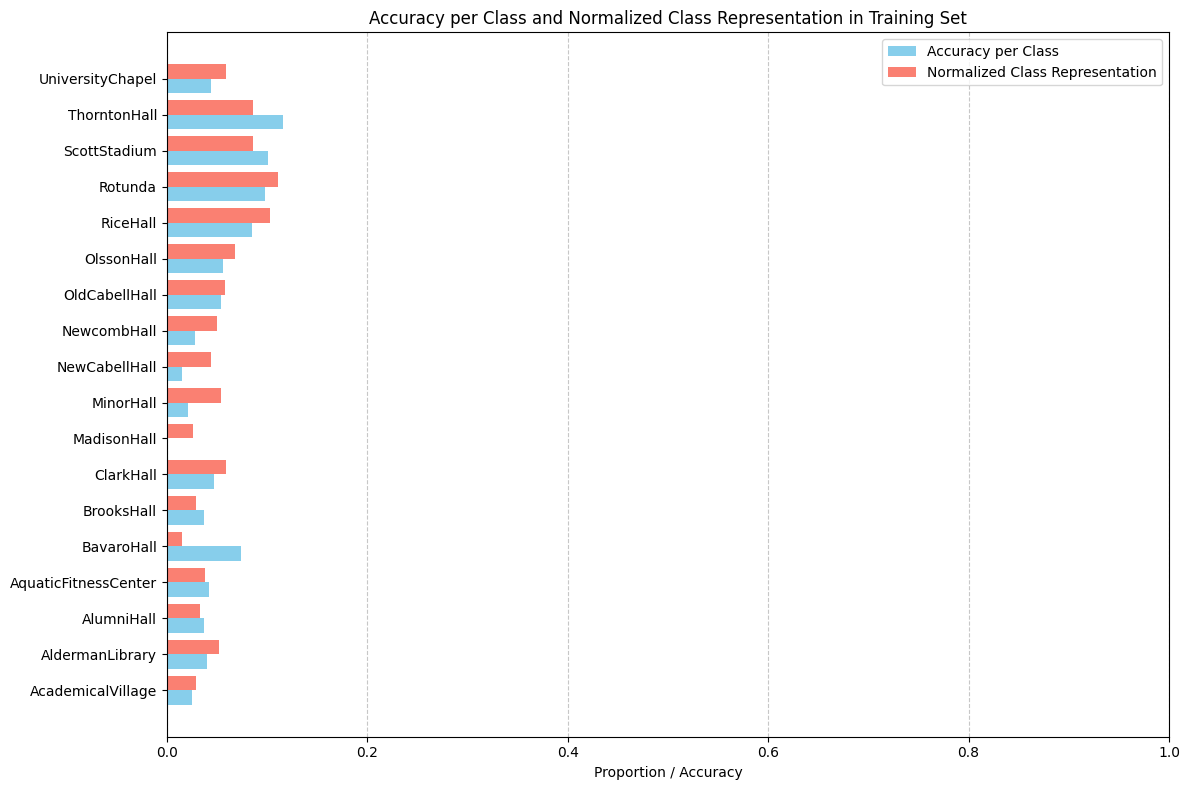

In [ ]:
from sklearn.metrics import accuracy_score

# Calculate accuracy per class
class_accuracies = []
for i, class_name in enumerate(class_names):
    # Get indices for instances of the current class
    class_indices = np.where(val_labels == i)[0]
    # Calculate accuracy for this class
    class_accuracy = accuracy_score(val_labels[class_indices], val_predictions[class_indices])
    class_accuracies.append(class_accuracy)

# Plot accuracy per class and normalized class representation
plt.figure(figsize=(12, 8))

# Bar width for side-by-side bars
bar_width = 0.4
index = np.arange(len(class_names))

# Plotting accuracy per class
plt.barh(index - bar_width/2, class_accuracies, bar_width, label='Accuracy per Class', color='skyblue')


train_labels = np.concatenate([y for x, y in train_ds], axis=0)
class_counts_train = [len(np.where(train_labels == i)[0]) for i in range(len(class_names))]
total_train_samples = sum(class_counts_train)
normalized_class_representation = [count / total_train_samples for count in class_counts_train]

# Plotting normalized class representation in training set
plt.barh(index + bar_width/2, normalized_class_representation, bar_width, label='Normalized Class Representation', color='salmon')

# Labeling
plt.xlabel('Proportion / Accuracy')
plt.title('Accuracy per Class and Normalized Class Representation in Training Set')
plt.yticks(index, class_names)
plt.xlim([0, 1])  # Limit x-axis from 0 to 1 for better interpretability
plt.legend()
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

                      Accuracy  Class Representation
Accuracy              1.000000              0.714993
Class Representation  0.714993              1.000000


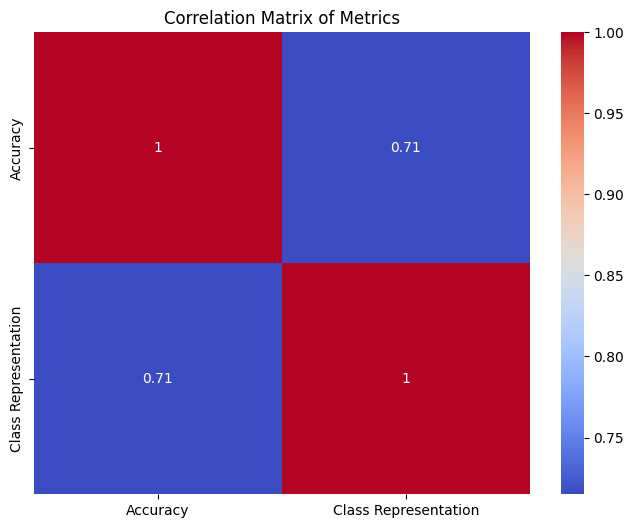

In [ ]:
import pandas as pd
import seaborn as sns

# Create a DataFrame
data = pd.DataFrame({
    'Class': class_names,
    'Accuracy': class_accuracies,
    'Class Representation': normalized_class_representation,
})

# Compute correlation matrix
correlation_matrix = data[['Accuracy', 'Class Representation']].corr()
print(correlation_matrix)

# Visualize the correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Metrics')
plt.show()

# Step 4: Reflection

Write at least a paragraph answering these prompts: How did your own network perform in comparison to the pre-trained one? What are the major differences between the architectures? Additionally, report on your experience implementing different models for this assignment (Was it hard/easy/fun?, from which part did you learn the most?)!

I had a lot of trouble with some of the training for the transfer learning model! I had spent a long time trying to training all sorts of models but all of them seems to be training extremely slowly and only reaching 70% after all was said and done. I eventually realized that I wasn't properly resizing my images and preprocessing to meet the needs of the pretrained models. I really enjoyed this project and I hope that the next one is as enjoyable as well.